In [30]:
#######################
## NODE MINI-PROJECT ##
#######################

## Author: Willem Bonnaffé (willem.bonnaffe@biology.ox.ac.uk or w.bonnaffe@gmail.com)

## Goals:
## (1) Load hare-lynx time series.
## (2) Apply the framework to fit the hare-lynx time series of prey-predator oscillations.
## (3) Assess the capacity of the framework to forecast future dynamics and backcast past dynamics.
## (4) Analyse the dynamics of hare and lynx (e.g. how does a change in the number of predators impact the prey dynamics? Are their non-linearities in the dynamics?).

## Methodological learning objectives:
## (1) Neural networks.
## (2) Neural ODEs.
## (3) Model optimisation in PyTorch.
## (4) Forecasting and backcasting using Neural ODEs.
## (5) State space visualisation and interpretation.

#
###

---
# 1. Setup

This Jupyter Notebook can be run using Google Colab. 
First, setup the repository in Google Colab by downloading the GitHub repository and installing additional libraries.

In [ ]:
############################
## SETUP FOR GOOGLE COLAB ##
############################

## Note: Only run this section if running code in Google Colab

## Clone GitHub repository
!git clone https://github.com/WillemBonnaffe/nodes-tutorial
%cd nodes-tutorial

## Download necessary dependences
!pip install torchdiffeq

#
###

In [1]:
####################
## INITIALIZATION ##
####################

## Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchdiffeq import odeint
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Set random seed for reproducibility
torch.manual_seed(0)

## Select device ("cuda", "mps", or "cpu")
DEVICE = "mps" # Replace with cuda if working in Colab

#
###

---
# 2. Load and visualise time series data

We load and explore the time series data of hare and lynx pelt counts collected in the Hudson Bay Area (Odum & Barrett 1971).
These time series correspond to pelt counts of hare and lynx collected by trappers.
The time series spans 90 years and displays 10-year long oscillations of hare and lynx.
This dataset famously provides an opportunity for understanding the coupling between prey and predator dynamics.

*References:*\
Odum, E.P. and Barrett, G.W., 1971. Fundamentals of ecology.

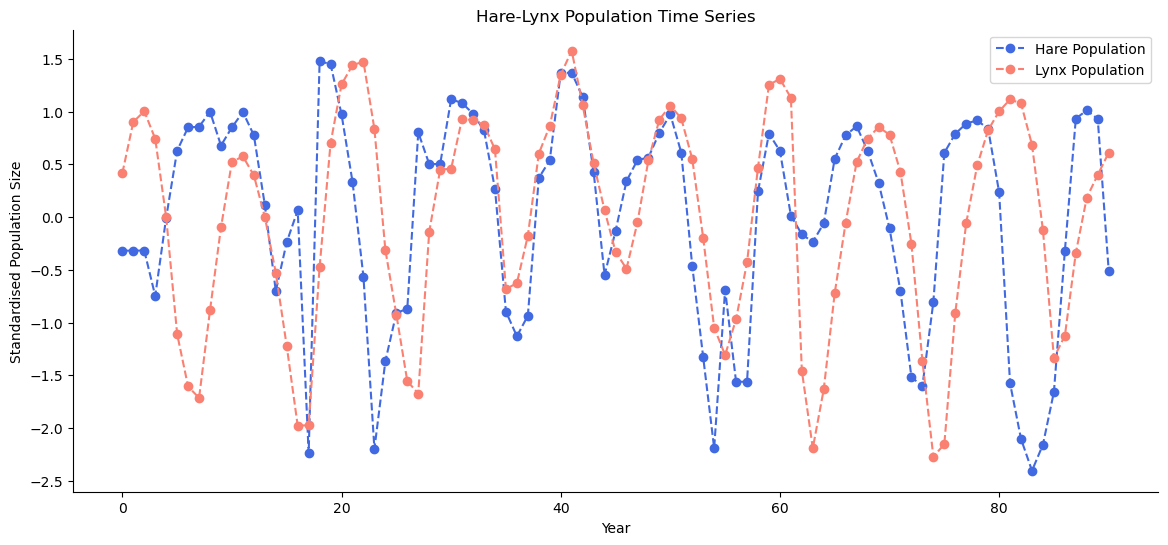

In [14]:
################################
## LOADING AND EXPLORING DATA ##
################################

## Goal:
## Load and preprocess the Hudson Bay Company’s hare-lynx dataset, visualize basic trends, and normalise data for model training.

## Load data function
## Goal:
## Load the hare-lynx dataset from a CSV file and preprocess for NODE training.
## Inputs:
## file_path (str): Path to the CSV file containing hare-lynx time series data.
## Outputs:
## data_tensor (torch.Tensor): Normalized hare-lynx population data as a PyTorch tensor.
def load_and_preprocess_data(file_path):

    ## Load the data
    data = np.array(pd.read_csv(file_path))
    data = data[:,1:3] # Drop time step

    ## Subset time steps
    # data = data[0:30]

    ## Normalize data to stabilize training
    data_normalized = np.copy(data)
    for i in range(data.shape[1]):
        data_log = np.log(data[:,i])
        data_normalized[:,i] = (data_log - data_log.mean()) / data_log.std()
    
    ## Convert data to PyTorch tensor
    data_tensor = torch.tensor(data_normalized, dtype=torch.float32)
    
    return data_tensor

## Load and visualize the data
data_tensor = load_and_preprocess_data('data_hare_lynx.csv')
num_time_steps = data_tensor.size()[0]
data_tensor = data_tensor.float()

## Plot the data to observe trends in hare and lynx populations
plt.figure(figsize=(14,6))
plt.plot(data_tensor[:, 0], '--o', label='Hare Population', color='royalblue')
plt.plot(data_tensor[:, 1], '--o', label='Lynx Population', color='salmon')
plt.xlabel('Year')
plt.ylabel('Standardised Population Size')
plt.legend()
plt.title('Hare-Lynx Population Time Series')
sns.despine()
plt.show()

#
###

# Questions:
* Describe the time series.
* Can you identify different stages within the time series? Propose hypotheses that may explain the observed shifts in the dynamics.

---
# 3. Model architecture

We investigate how the dynamics of the populations change through time using neural ordinary differential equations.
Neural ODEs allow us to non-parametrically model how variables interact to drive the dynamics of the system.
Non-parametrically means that we do not have to propose a mechanism for the relationship between variables.
This is particularly useful if want to know how variables influence each other, without biasing our analysis by presuming a specific mathematical construction.

For example, in this system, we could use the Lotka-Volterra model to represent how hare growth is influence by lynx density. We could also include other processes such as intraspecific density-dependence, and to do so we could choose many different equations.
In doing that, we risk choosing an unsuitable equation which will bias our analysis.
Neural networks let the functional form of the relationship between hare and lynx be determined by the data.

In this section, we define a neural ODE with explicit dependence on time. The model writes as follows,

\begin{equation}
\frac{dX(t)}{dt} = f(t, X(t); \Omega),
\end{equation}

where $\frac{dX(t)}{dt}$ denotes the dynamics of the system, namely the combined temporal dynamics of the hare and of the lynx populations, i.e. $\frac{dX(t)}{dt} = \left[ \frac{dH(t)}{dt}, \frac{dL(t)}{dt} \right]$.
$f(.)$ is a neural network that takes the time, $t$, as input, as well as the state of the system, $X(t) = [H(t), L(t)]$, which itself is defined as the density of hare and lynx in the study area (i.e. in individuals per unit of surface).

In this implementation, we introduce an explicit dependence of the dynamics on time using a sinusoid function,

\begin{equation}
\tilde{t} = A \cdot \mathrm{sin}(\omega t + \phi) + \delta
\end{equation}

where $A$ is the amplitude, $\omega$ is the frequency, $\phi$ is the phase, and $\delta$ is the intercept.

References:
- Bonnaffé, W., Sheldon, B.C. and Coulson, T., 2021. Neural ordinary differential equations for ecological and evolutionary time‐series analysis. Methods in Ecology and Evolution, 12(7), pp.1301-1315.
- Bonnaffé, W. and Coulson, T., 2023. Fast fitting of neural ordinary differential equations by Bayesian neural gradient matching to infer ecological interactions from time‐series data. Methods in Ecology and Evolution, 14(6), pp.1543-1563.

In [3]:
##################
## DEFINE MODEL ##
##################

## Goal:
## Define a NODE model with time-dependent dynamics by using the sine of the time step as an additional input.
## This allows the model dynamics to change periodically based on time.

## Extended NODE model class with learnable time-dependence parameters
## Goal:
## Define a neural network with time as an additional input, where time is represented as a sinusoidal function
## modified by learnable amplitude, phase, shift, and frequency parameters.
## Inputs:
## t (float): Current time step.
## x (torch.Tensor): Population densities (hare and lynx).
## Outputs:
## dX/dt (torch.Tensor): Derivative of hare and lynx populations.
class PredatorPreyODE_TimeDependent(nn.Module):

    def __init__(self):
        super(PredatorPreyODE_TimeDependent, self).__init__()

        ## Define trainable parameters for the sinusoidal time input
        self.amplitude = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))  # Amplitude of the sine wave
        self.phase = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))      # Phase shift of the sine wave
        self.frequency = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))  # Frequency of the sine wave
        self.shift = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))      # Vertical shift of the sine wave

        ## Define the neural network for dynamics prediction
        self.net = nn.Sequential(
            nn.Linear(3, 50),   # Input layer with hare, lynx, and adjusted time
            nn.Tanh(),
            nn.Linear(50, 2)    # Output layer with two outputs: dHare/dt, dLynx/dt
        )

    def forward(self, t, x):
        ## Modify the sinusoidal time input with learnable parameters
        time_input = self.amplitude * torch.sin(self.frequency * t + self.phase) + self.shift

        ## Append the modified time input to the hare and lynx populations
        input_with_time = torch.cat((x, time_input.unsqueeze(0)), dim=0)
        return self.net(input_with_time)

#
###

# Questions:
* How do the elements in the code relate to the elements in the equations?
* List some of the assumptions made regarding the dynamics of the populations and how they depend on time and state variables.
* Propose biological explanations for introducing an explicit dependence on time in the dynamics of the hare and lynx populations.

---
# 4. Model fitting 

In this section, we fit the time-dependent NODE model to the hare-lynx time series using the gradient-descent optimisation in PyTorch.

In [17]:
############################
## FUNCTIONS FOR TRAINING ##
############################

## Goal: 
## Define functions to train the model.

## training_loop_time_dependent function
## Goal:
## Train the NODE model with periodic time input over a specified number of epochs.
## Inputs:
## model (nn.Module): The NODE model with time input to be trained.
## optimizer (torch.optim.Optimizer): Optimizer for adjusting model weights.
## data (torch.Tensor): Time series data of hare and lynx populations.
## epochs (int): Number of epochs to run the training loop.
## Outputs:
## None
def training_loop_time_dependent(model, optimizer, data, epochs):

    ## Time points
    time_points = torch.linspace(0, data.shape[0], steps=data.shape[0], device=data.device, dtype=torch.float32)  # Define time points over one period

    for epoch in range(epochs):

        ## Set gradients to zero before each pass
        optimizer.zero_grad()

        ## Forward pass: use ODE solver to predict populations over time
        predicted_population = odeint(model, initial_conditions, time_points, rtol=1e-5, atol=1e-6, method="rk4")

        ## Compute loss as MSE between predicted and actual hare-lynx data
        loss = mse_loss(predicted_population, data)

        ## Backward pass: compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        ## Log training progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

## evaluate_model_time_dependent function
## Goal:
## Evaluate the time-dependent NODE model by comparing predictions of hare and lynx populations to actual data.
## Inputs:
## model (nn.Module): The trained NODE model with time input.
## data (torch.Tensor): Time series data of hare and lynx populations.
## Outputs:
## final_loss (float): Final MSE loss after model training.
def evaluate_model_time_dependent(model, data):

    ## Time points
    time_points = torch.linspace(0, data.shape[0], steps=data.shape[0], device=data.device, dtype=torch.float32)  # Define time points over one period

    ## Perform forward pass to get model predictions
    predicted_population = odeint(model, initial_conditions, time_points, rtol=1e-5, atol=1e-6, method="rk4")
    
    ## Calculate final MSE loss on the dataset
    final_loss = mse_loss(predicted_population, data).item()
    print(f"Loss: {final_loss:.4f}")

    ## Convert to numpy
    data = data.detach().cpu().numpy()
    predicted_population = predicted_population.detach().cpu().numpy()
    
    ## Visualize the results
    plt.figure(figsize=(14,6))
    plt.plot(data[:, 0], '--o', label="True Hare Population", color='royalblue')
    plt.plot(data[:, 1], '--o', label="True Lynx Population", color='salmon')
    plt.plot(predicted_population[:, 0], label="Predicted Hare with Time Input", color='royalblue')
    plt.plot(predicted_population[:, 1], label="Predicted Lynx with Time Input", color='salmon')
    plt.xlabel('Year')
    plt.ylabel('Standardised Population Size')
    plt.legend()
    plt.title('True vs Predicted Hare-Lynx Dynamics with Time Input')
    plt.show()

    return final_loss

#
###

# Questions:
* Identify the four key steps for each epoch in the training loop.
* What do these steps correspond to?

In [5]:
####################
## INITIATE MODEL ##
####################

## Goal: 
## Instantiate the model, set initial conditions, define the loss, and instantiate the optimiser.

## Initialize the time-dependent model
predator_prey_ode_time_dependent = PredatorPreyODE_TimeDependent()

## Define initial conditions for hare and lynx populations
initial_conditions = data_tensor[0]  # Initial hare and lynx values from the data

## Define training parameters
mse_loss = nn.MSELoss()
optimizer_time_dependent = optim.Adam(predator_prey_ode_time_dependent.parameters(), lr=0.001, weight_decay=0.001)
num_epochs = 1000

#
###

In [19]:
###################################
## LOAD MODEL AND DATA TO DEVICE ##
###################################

## Goal: 
## In order to use GPU acceleration, the data and model have to be copied onto the GPU first.

predator_prey_ode_time_dependent = predator_prey_ode_time_dependent.to(DEVICE)
data_tensor = data_tensor.to(DEVICE)
initial_conditions = initial_conditions.to(DEVICE)

#
##

Epoch 0/1000, Loss: 1.7696
Epoch 100/1000, Loss: 0.4561
Epoch 200/1000, Loss: 0.3688
Epoch 300/1000, Loss: 0.2738
Epoch 400/1000, Loss: 0.2520
Epoch 500/1000, Loss: 0.2319
Epoch 600/1000, Loss: 0.2202
Epoch 700/1000, Loss: 0.2002
Epoch 800/1000, Loss: 0.1842
Epoch 900/1000, Loss: 0.1823
Final Loss (with Time Input): 147.6908


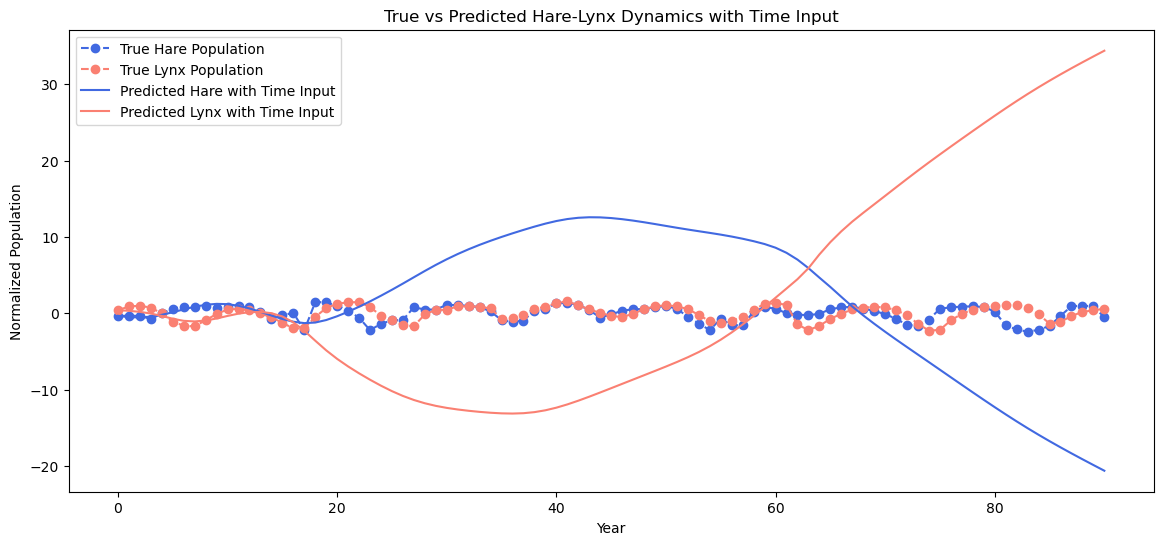

Epoch 0/1000, Loss: 20.9662
Epoch 100/1000, Loss: 0.8379
Epoch 200/1000, Loss: 0.8158
Epoch 300/1000, Loss: 0.8053
Epoch 400/1000, Loss: 0.7955
Epoch 500/1000, Loss: 0.7850
Epoch 600/1000, Loss: 0.7739
Epoch 700/1000, Loss: 0.7622
Epoch 800/1000, Loss: 0.7493
Epoch 900/1000, Loss: 0.7340
Final Loss (with Time Input): 1.1791


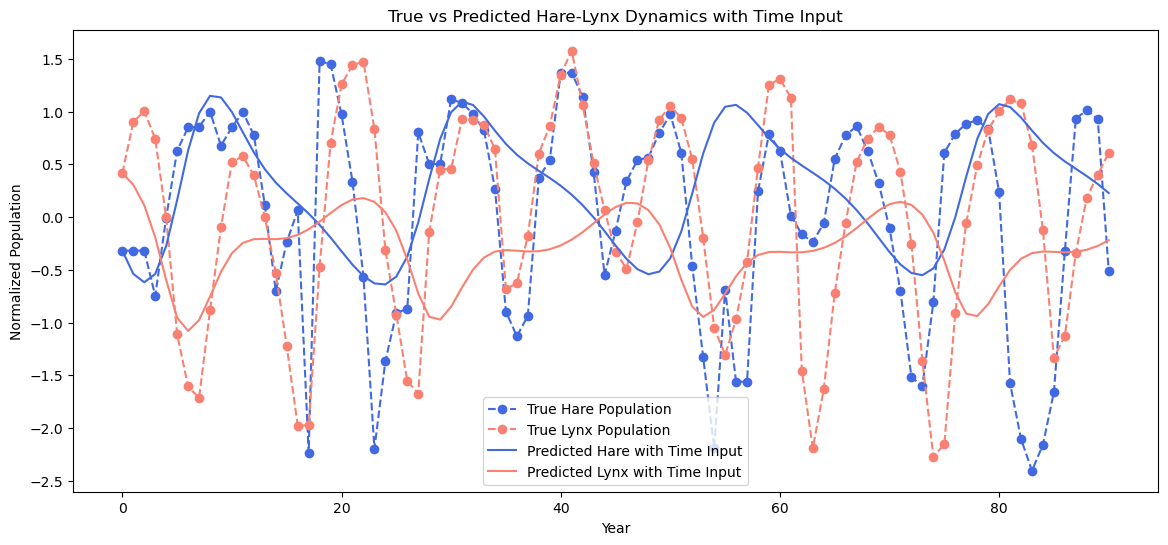

Epoch 0/1000, Loss: 0.8083
Epoch 100/1000, Loss: 0.6779
Epoch 200/1000, Loss: 0.5795
Epoch 300/1000, Loss: 0.5618
Epoch 400/1000, Loss: 0.5507
Epoch 500/1000, Loss: 0.5414
Epoch 600/1000, Loss: 0.5322
Epoch 700/1000, Loss: 0.5225
Epoch 800/1000, Loss: 0.5118
Epoch 900/1000, Loss: 0.4998
Final Loss (with Time Input): 1.2368


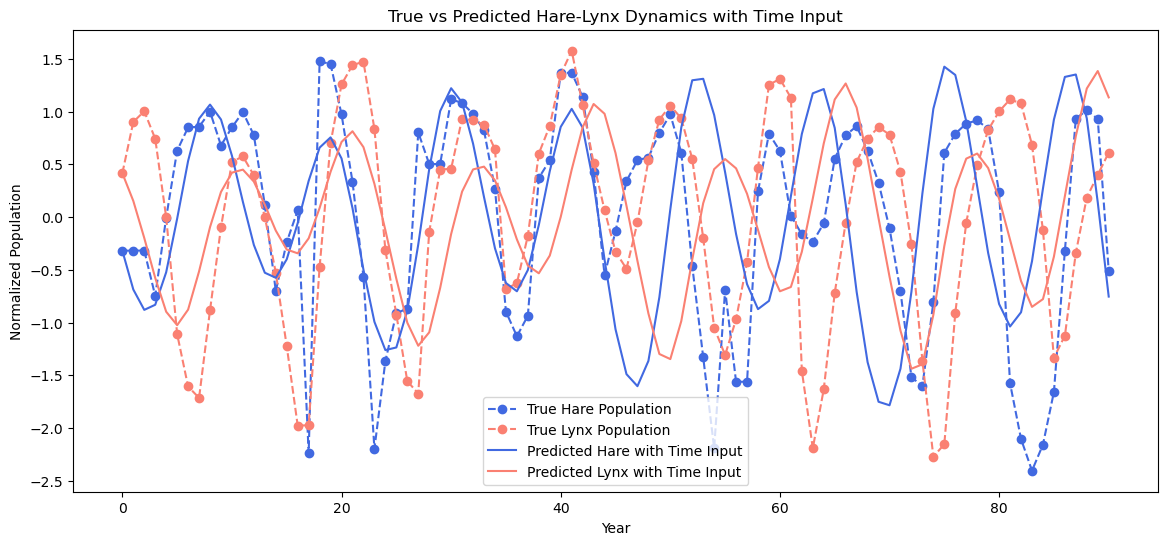

Epoch 0/1000, Loss: 0.9520
Epoch 100/1000, Loss: 0.5710
Epoch 200/1000, Loss: 0.5052
Epoch 300/1000, Loss: 0.4504
Epoch 400/1000, Loss: 0.4152
Epoch 500/1000, Loss: 0.3963
Epoch 600/1000, Loss: 0.3842
Epoch 700/1000, Loss: 0.3744
Epoch 800/1000, Loss: 0.3661
Epoch 900/1000, Loss: 0.3588
Final Loss (with Time Input): 1.4513


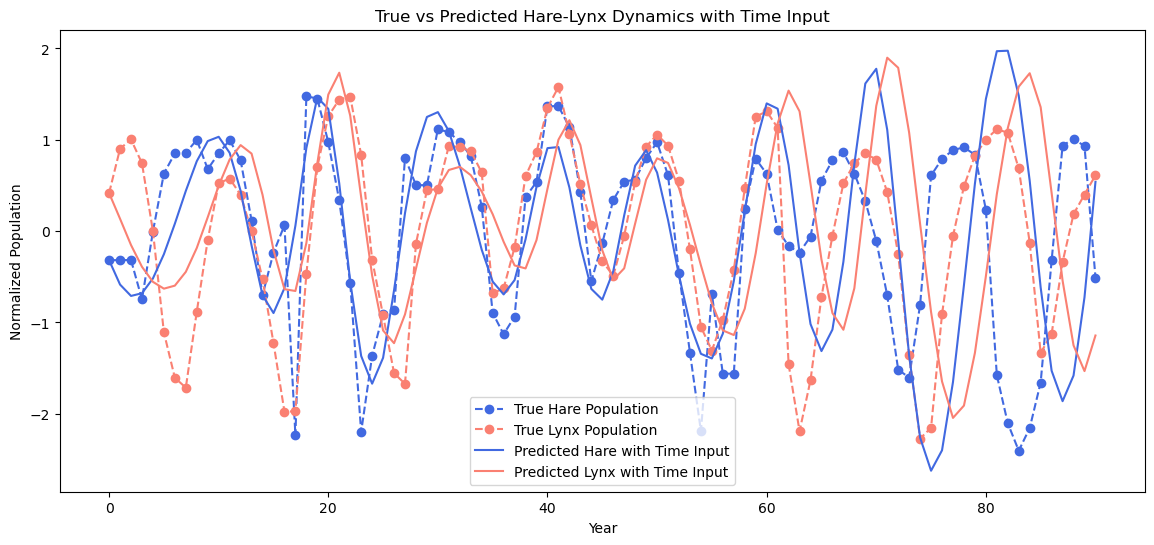

Epoch 0/1000, Loss: 1.4401
Epoch 100/1000, Loss: 0.9244
Epoch 200/1000, Loss: 0.8745
Epoch 300/1000, Loss: 0.4314
Epoch 400/1000, Loss: 0.3863
Epoch 500/1000, Loss: 0.3784
Epoch 600/1000, Loss: 0.3732
Epoch 700/1000, Loss: 0.3694
Epoch 800/1000, Loss: 0.3663
Epoch 900/1000, Loss: 0.3637
Final Loss (with Time Input): 0.3776


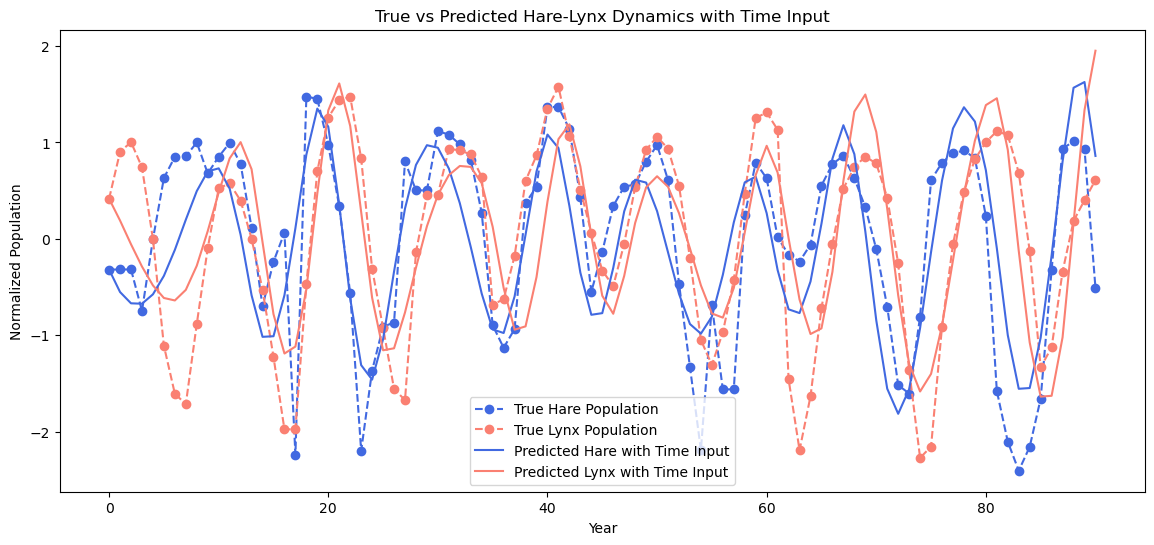

In [22]:
#############################
## TRAINING AND EVALUATION ##
#############################

## Goal:
## Execute the training loop and evaluate the NODE model with time input on the hare-lynx dataset.

for t_max in [15, 30, 45, 60, 90]:

    print(f"t_max = {t_max} years")

    ## Run training loop for model with time input
    t0 = time.time()
    training_loop_time_dependent(model=predator_prey_ode_time_dependent, optimizer=optimizer_time_dependent, data=data_tensor[0:t_max], epochs=num_epochs)    
    tf = time.time()
    print(f"Runtime: {tf-t0:.2f}s")
            
    ## Evaluate model after training
    final_loss_time_dependent = evaluate_model_time_dependent(predator_prey_ode_time_dependent, data_tensor)
    
#
###

# Questions (while the model is training):
* Why do we run the training sequentially considering increasing portions of the data?
* Draw a graphical representation of the model architecture showing the inputs to the neural network, the hidden layer, and the outputs.

In [16]:
##################
## SAVE WEIGHTS ##
##################

## Goal:
## Save the weights of the neural network for future experimentation.
## This creates a local copy of the weights of the neural network.

SAVE = False
if SAVE:
    torch.save(predator_prey_ode_time_dependent.state_dict(), "predator-prey-time-dependent-2026-02-11-1.pth")

#
###

---
# 5. Model analysis

In [7]:
##################
## LOAD WEIGHTS ##
##################

## Goal:
## Load the weights of the model for analysis.

state_dict = torch.load("predator-prey-time-dependent-2026-02-02-1.pth", map_location="mps")
predator_prey_ode_time_dependent.load_state_dict(state_dict)

#
###

<All keys matched successfully>

Loss: 0.3776


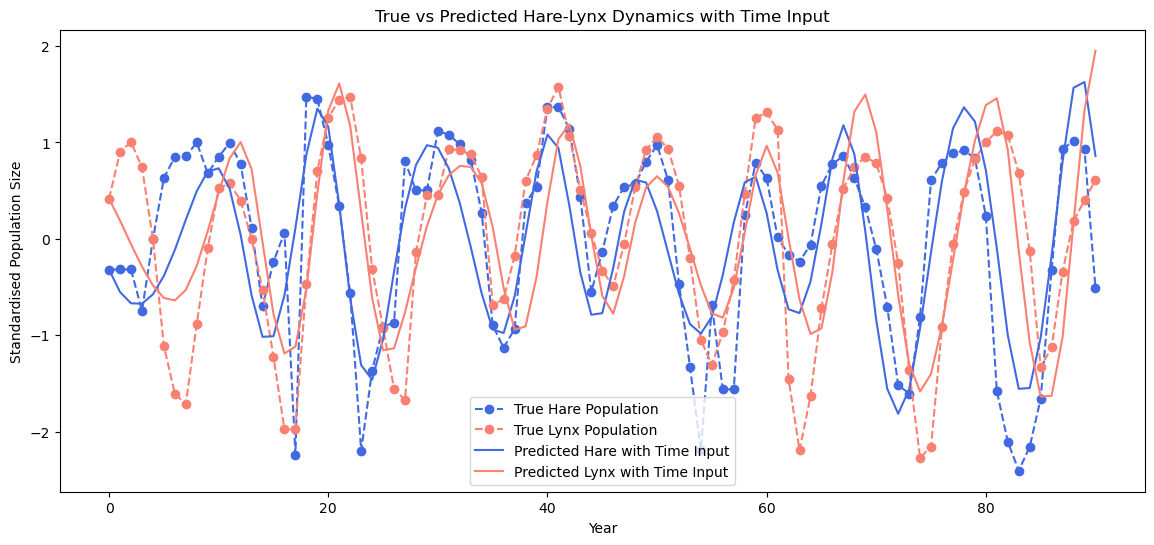

In [20]:
#####################
## CHECK MODEL FIT ##
#####################

## Goal:
## Assess how well the model fits the time series.

## Evaluate model after training
predator_prey_ode_time_dependent.eval()  # important for inference
final_loss_time_dependent = evaluate_model_time_dependent(predator_prey_ode_time_dependent, data_tensor)

#
###

# Questions:
* Describe the fit.
* Compare the fit of your model to a previously trained model `predator-prey-time-dependent-2026-02-02-1.pth`.
* Conclude on which is better and proceed with this one for the rest of the analysis.

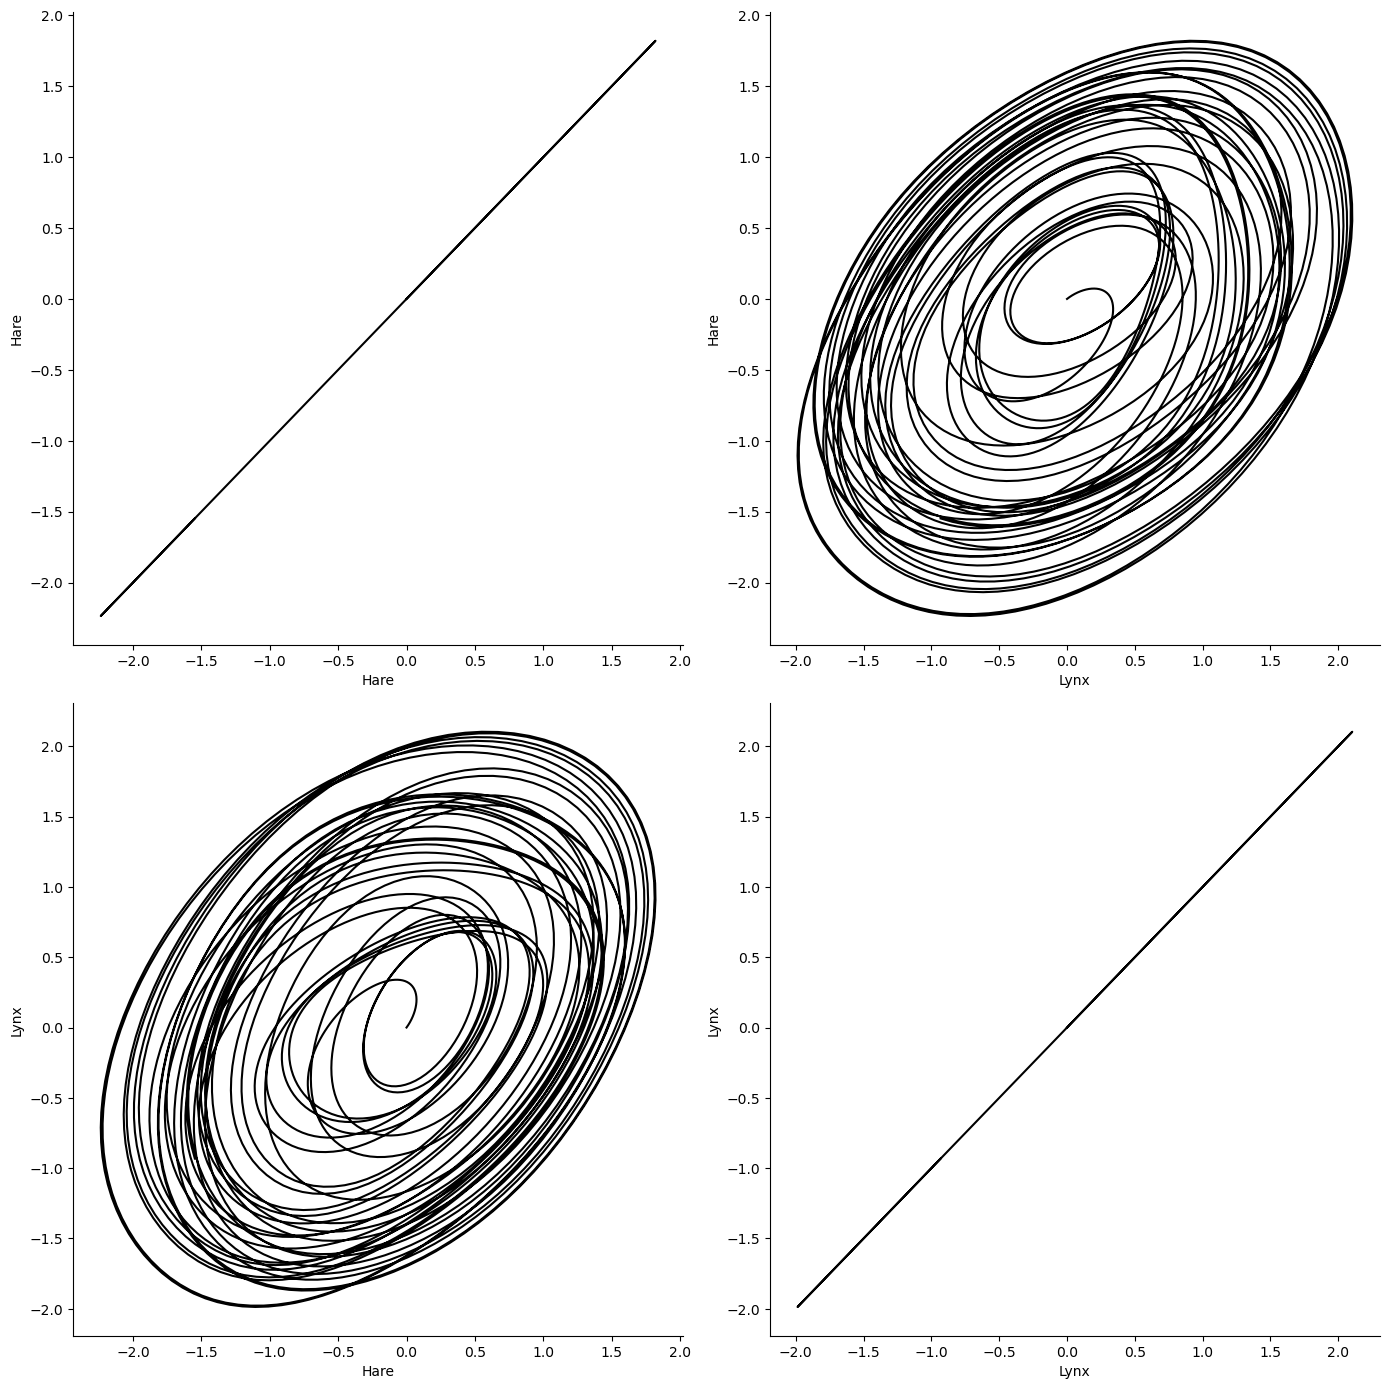

In [29]:
##########################################
## VISUALISATION OF PREY-PREDATOR CYCLE ##
##########################################

## Goal:
## Visualise prey predator cycles.

## Define time steps for forecasting beyond training data range
forecast_time_steps = torch.linspace(0, num_time_steps * 4, steps=num_time_steps * 40, device=DEVICE)  # Forecast for twice the time range as training data

## Perform forecasting
initial_states = torch.tensor([0,0], device=DEVICE).float()
forecasted_population = odeint(predator_prey_ode_time_dependent, initial_states, forecast_time_steps, rtol=1e-5, atol=1e-6, method="rk4")

## Detach 
forecasted_population = forecasted_population.cpu().detach().numpy()

## Visualize forecasted populations
num_variables = 2
fig, axes = plt.subplots(num_variables, num_variables, figsize=(14,14))
var_labels = ['Hare','Lynx']
t = np.arange(forecasted_population.shape[0])  # time index
for i in range(num_variables):
    for j in range(num_variables):
        axis = axes[i,j]        
        axis.plot(forecasted_population[:, j], forecasted_population[:, i], '-', label="", color='black', alpha=1.0)
        # axis.scatter(forecasted_population[:, j], forecasted_population[:, i], c=t, cmap='rainbow', alpha=0.5)
        axis.set_xlabel(var_labels[j])
        axis.set_ylabel(var_labels[i])
sns.despine()
plt.tight_layout()
plt.show()

#
###

# Question:
* Describe and interpret the figure.

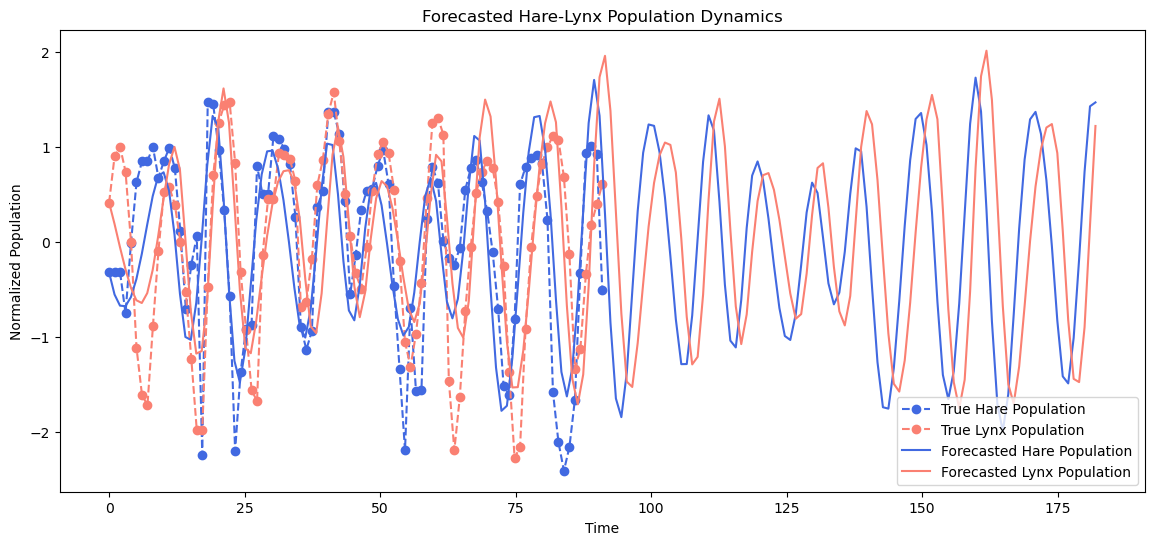

In [10]:
##########################
## FORECASTING ANALYSIS ##
##########################

## Goal:
## Test the NODE model's ability to forecast future hare and lynx population dynamics.

## Define time steps for forecasting beyond training data range
time_steps = torch.linspace(0, num_time_steps, steps=num_time_steps, device=DEVICE)
forecast_time_steps = torch.linspace(0, num_time_steps * 2, steps=num_time_steps * 2, device=DEVICE)  # Forecast for twice the time range as training data

## Perform forecasting
forecasted_population = odeint(predator_prey_ode_time_dependent, data_tensor[0], forecast_time_steps, rtol=1e-5, atol=1e-6, method="rk4")

## Detach and copy to CPU
time_steps_numpy = time_steps.detach().cpu().numpy()
data_numpy = data_tensor.detach().cpu().numpy()
forecast_time_steps_numpy = forecast_time_steps.detach().cpu().numpy()
forecasted_population_numpy = forecasted_population.detach().cpu().numpy()

## Visualize forecasted populations
plt.figure(figsize=(14,6))
plt.plot(time_steps_numpy, data_numpy[:, 0], '--o', label="True Hare Population", color='royalblue')
plt.plot(time_steps_numpy, data_numpy[:, 1], '--o', label="True Lynx Population", color='salmon')
plt.plot(forecast_time_steps_numpy, forecasted_population_numpy[:, 0], '-', label="Forecasted Hare Population", color='royalblue')
plt.plot(forecast_time_steps_numpy, forecasted_population_numpy[:, 1], '-', label="Forecasted Lynx Population", color='salmon')
plt.xlabel('Time (yr)')
plt.ylabel('Standardised Population Size')
plt.legend()
plt.title('Forecasted Hare-Lynx Population Dynamics')
plt.show()

#
###

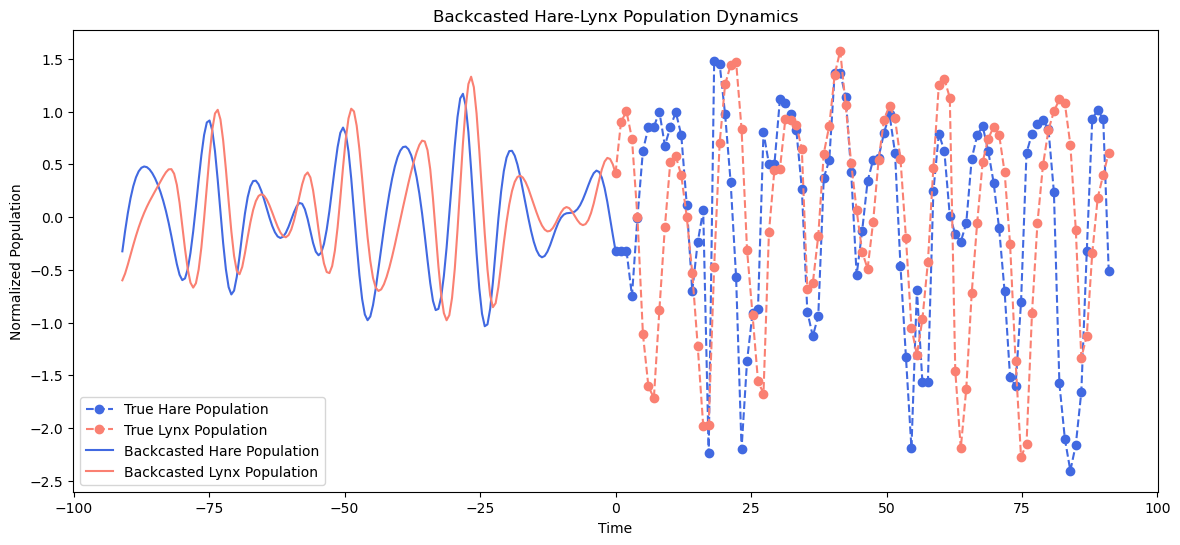

In [11]:
##########################
## BACKCASTING ANALYSIS ##
##########################

## Goal:
## Test the NODE model's ability to backcast previous hare and lynx population dynamics by integrating backwards in time.

## Define time steps for backcasting prior to the training data range
time_steps = torch.linspace(0, num_time_steps, steps=num_time_steps)
backcast_time_steps = torch.linspace(0, -num_time_steps, steps=num_time_steps * 2, device=DEVICE)  # Backcast by integrating backwards in time

## Perform backcasting
backcasted_population = odeint(predator_prey_ode_time_dependent, data_tensor[0], backcast_time_steps, rtol=1e-5, atol=1e-6, method="rk4")

## Detach and copy to CPU
time_steps_numpy = time_steps.detach().cpu().numpy()
data_numpy = data_tensor.detach().cpu().numpy()
backcast_time_steps_numpy = backcast_time_steps.detach().cpu().numpy()
backcasted_population_numpy = backcasted_population.detach().cpu().numpy()

## Visualize backcasted populations
plt.figure(figsize=(14,6))
plt.plot(time_steps_numpy, data_numpy[:, 0], '--o', label="True Hare Population", color='royalblue')
plt.plot(time_steps_numpy, data_numpy[:, 1], '--o', label="True Lynx Population", color='salmon')
plt.plot(backcast_time_steps_numpy, backcasted_population_numpy[:, 0], '-', label="Backcasted Hare Population", color='royalblue')
plt.plot(backcast_time_steps_numpy, backcasted_population_numpy[:, 1], '-', label="Backcasted Lynx Population", color='salmon')
plt.xlabel('Time (yr)')
plt.ylabel('Standardised Population Size')
plt.legend()
plt.title('Backcasted Hare-Lynx Population Dynamics')
plt.show()

#
###

# Question:
* Comment on the capacity of the model to forecast and backcast.

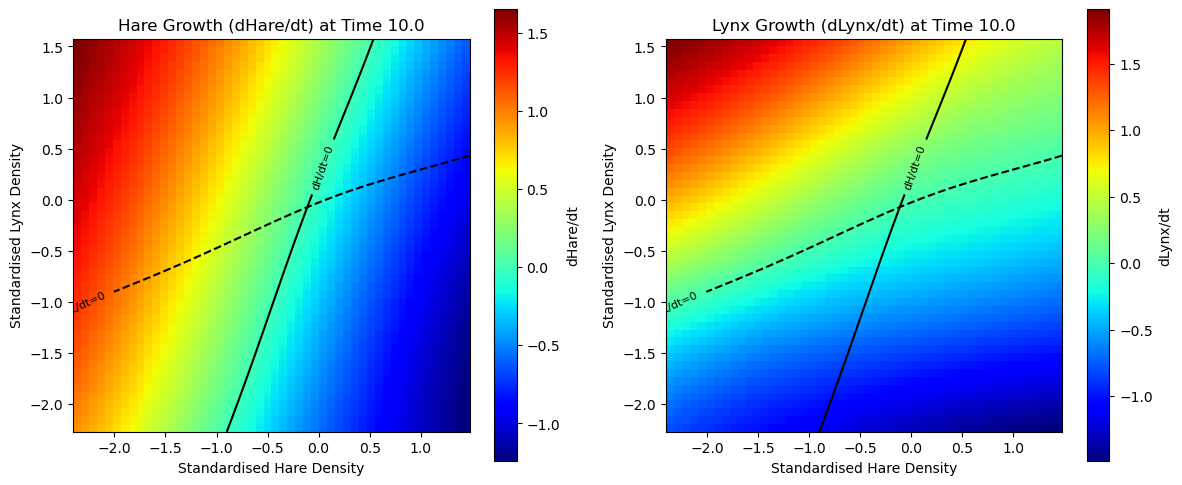

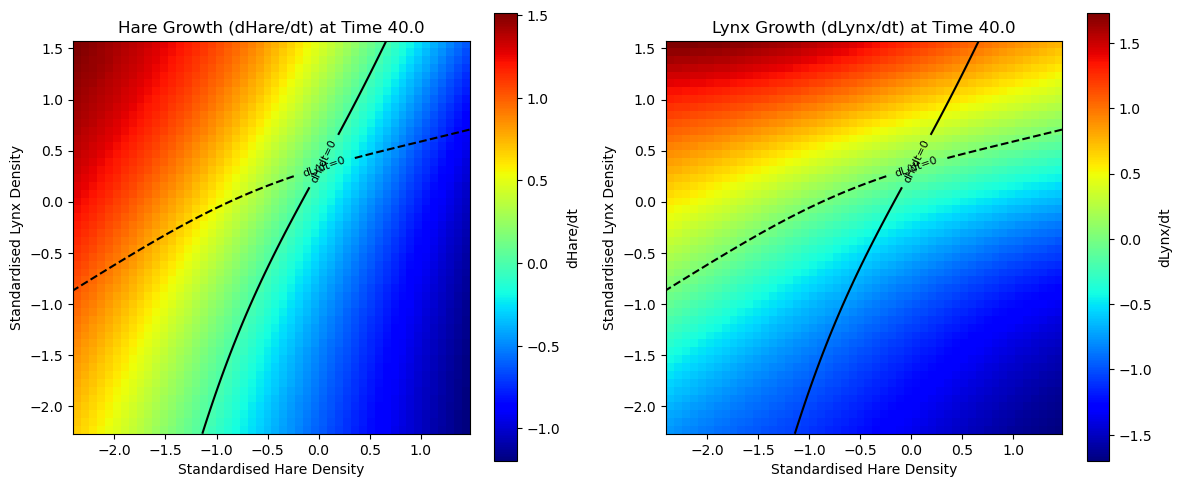

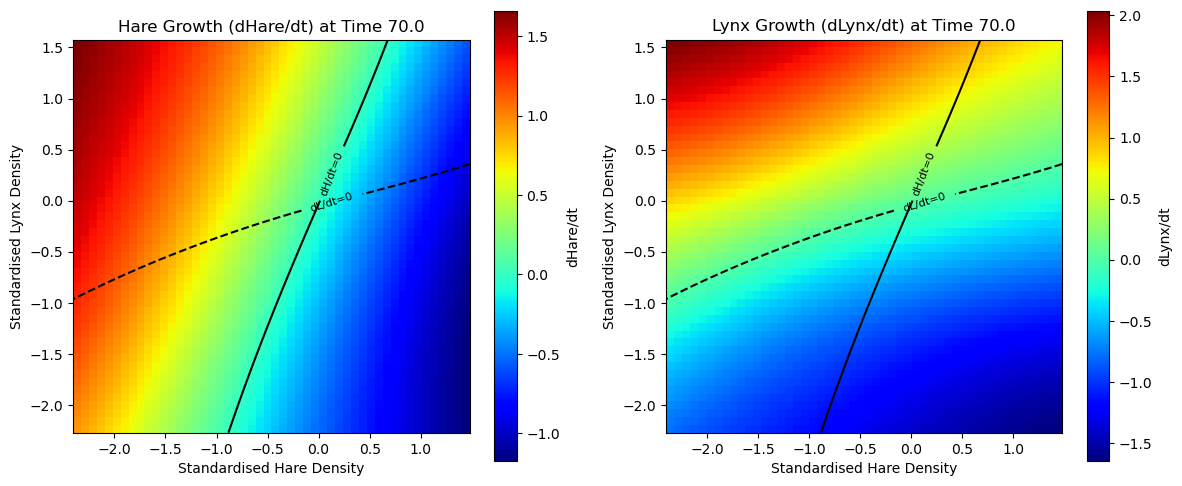

In [15]:
#######################################
## ANALYSIS: PREDICTED DYNAMICS GRID ##
#######################################

## Goal:
## Evaluate NODE model dynamics over a grid of hare and lynx densities at a specific time point.
## Display two heatmaps showing the predicted dynamics of hare and lynx populations.

import numpy as np
import matplotlib.pyplot as plt

## dynamics_grid_analysis_time_dependent function
## Goal:
## Evaluate NODE model dynamics over a grid of hare and lynx densities, incorporating sinusoidal time input.
## Inputs:
## model (nn.Module): Trained NODE model (time-dependent).
## hare_range (tuple of float): Range of hare densities to evaluate (min, max).
## lynx_range (tuple of float): Range of lynx densities to evaluate (min, max).
## time_value (float): Time value used for the sinusoidal input.
## grid_size (int): Number of points along each axis in the grid (default=50).
## Outputs:
## None
def dynamics_grid_analysis_time_dependent(model, hare_range, lynx_range, time_value, grid_size=50):

    ## Make sure all objects are on CPU
    model = model.cpu()
    time_value = time_value.cpu()
    
    ## Create mesh grid for hare and lynx densities
    hare_values = np.linspace(hare_range[0], hare_range[1], grid_size)
    lynx_values = np.linspace(lynx_range[0], lynx_range[1], grid_size)
    hare_grid, lynx_grid = np.meshgrid(hare_values, lynx_values)

    ## Initialize arrays to store dynamics predictions for each grid point
    hare_dynamics = np.zeros((grid_size, grid_size))
    lynx_dynamics = np.zeros((grid_size, grid_size))
    
    ## Evaluate dynamics across the grid
    for i in range(grid_size):
        for j in range(grid_size):
            
            ## Prepare hare, lynx, and time inputs as a torch tensor for model input
            hare_density = hare_values[i]
            lynx_density = lynx_values[j]            
            input_tensor = torch.tensor([hare_density, lynx_density], dtype=torch.float32)

            ## Convert t to tensor
            # t_tensor = torch.tensor(time_value, dtype=torch.float32)  # Time placeholder
            
            ## Get dynamics prediction (dHare/dt, dLynx/dt) from the model
            dynamics = model(time_value, input_tensor)
            
            ## Store the predicted dynamics in the arrays
            hare_dynamics[i, j] = dynamics[0].item() # dHare/dt
            lynx_dynamics[i, j] = dynamics[1].item() # dLynx/dt

    ## Plot heatmap for hare population dynamics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(hare_dynamics, extent=(hare_range[0], hare_range[1], lynx_range[0], lynx_range[1]), origin='lower', cmap='jet')
    plt.colorbar(label='dHare/dt')
    plt.xlabel("Standardised Hare Density")
    plt.ylabel("Standardised Lynx Density")
    plt.title(f"Hare Growth (dHare/dt) at Time {time_value}")

    ## Null isoclines
    CS1 = plt.contour(hare_grid.T, lynx_grid.T, hare_dynamics.T, levels=[0], colors='black', linewidths=1.5)
    CS2 = plt.contour(hare_grid.T, lynx_grid.T, lynx_dynamics.T, levels=[0], colors='black', linewidths=1.5, linestyles='--')
    plt.clabel(CS1, fmt='dH/dt=0', inline=True, fontsize=8)
    plt.clabel(CS2, fmt='dL/dt=0', inline=True, fontsize=8)

    ## Plot heatmap for lynx population dynamics
    plt.subplot(1, 2, 2)
    plt.imshow(lynx_dynamics, extent=(hare_range[0], hare_range[1], lynx_range[0], lynx_range[1]), origin='lower', cmap='jet')
    plt.colorbar(label='dLynx/dt')
    plt.xlabel("Standardised Hare Density")
    plt.ylabel("Standardised Lynx Density")
    plt.title(f"Lynx Growth (dLynx/dt) at Time {time_value}")

    ## Null isoclines
    CS3 = plt.contour(hare_grid.T, lynx_grid.T, hare_dynamics.T, levels=[0], colors='black', linewidths=1.5)
    CS4 = plt.contour(hare_grid.T, lynx_grid.T, lynx_dynamics.T, levels=[0], colors='black', linewidths=1.5, linestyles='--')
    plt.clabel(CS3, fmt='dH/dt=0', inline=True, fontsize=8)
    plt.clabel(CS4, fmt='dL/dt=0', inline=True, fontsize=8)    
    
    plt.tight_layout()
    plt.show()


## Running dynamics grid analysis for the time-dependent model
## Define hare and lynx density ranges based on the observed data
hare_min, hare_max = data_tensor[:, 0].min().item(), data_tensor[:, 0].max().item()
lynx_min, lynx_max = data_tensor[:, 1].min().item(), data_tensor[:, 1].max().item()

## Execute analysis at different time values
dynamics_grid_analysis_time_dependent(predator_prey_ode_time_dependent, hare_range=(hare_min, hare_max), lynx_range=(lynx_min, lynx_max), time_value=torch.tensor(10.0))
dynamics_grid_analysis_time_dependent(predator_prey_ode_time_dependent, hare_range=(hare_min, hare_max), lynx_range=(lynx_min, lynx_max), time_value=torch.tensor(40.0))
dynamics_grid_analysis_time_dependent(predator_prey_ode_time_dependent, hare_range=(hare_min, hare_max), lynx_range=(lynx_min, lynx_max), time_value=torch.tensor(70.0))

#
###

# Question:
* Explain this figure.
* Do you notice differences between the dynamics estimated at different time steps?
* Are those consistent with the shifts in the dynamics that you observed earlier?

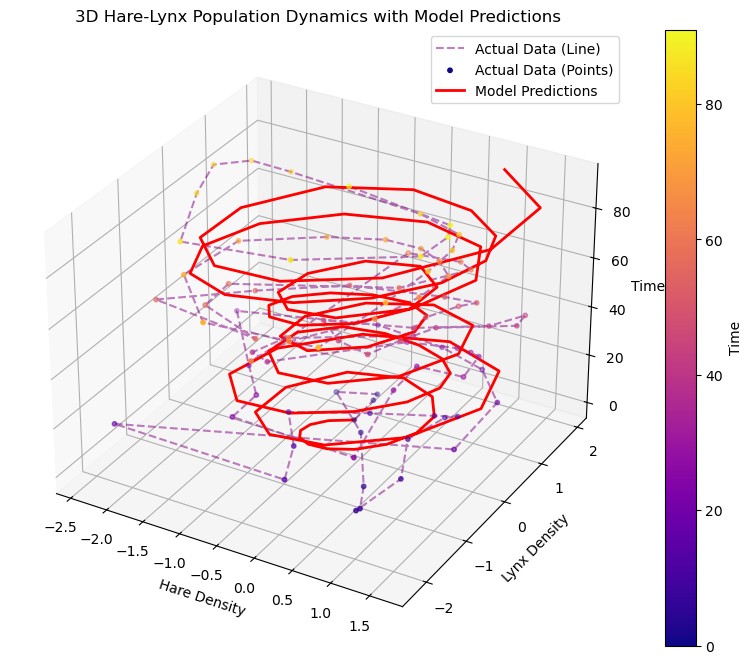

In [13]:
##############################################
## 3D VISUALIZATION OF HARE-LYNX POPULATION ##
##############################################

## Goal:
## Visualize the hare and lynx population densities and model predictions over time in a 3D plot.
## Actual data points are shown with a color gradient, and the model predictions are added as a separate line.

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

## Prepare data for 3D plot
hare_density = data_tensor[:, 0]  # Hare population density
lynx_density = data_tensor[:, 1]  # Lynx population density
# time_steps = np.arange(num_time_steps, device=DEVICE)    # Time steps
time_steps = torch.linspace(0, num_time_steps, steps=num_time_steps, device=DEVICE)

## Generate model predictions for the time-dependent model
time_tensor = torch.linspace(0, num_time_steps, steps=num_time_steps, dtype=torch.float32, device=DEVICE)  # Time steps for predictions
initial_conditions = data_tensor[0].to(DEVICE) # Initial conditions (hare, lynx)
predator_prey_ode_time_dependent = predator_prey_ode_time_dependent.to(DEVICE)

## Pass the initial conditions through the time-dependent NODE model
model_predictions = odeint(predator_prey_ode_time_dependent, initial_conditions, time_tensor, rtol=1e-5, atol=1e-6, method="rk4").detach().cpu().numpy()
predicted_hare = model_predictions[:, 0]  # Predicted hare population
predicted_lynx = model_predictions[:, 1]  # Predicted lynx population

## Convert to numpy
time_steps_numpy = time_steps.detach().cpu().numpy()
hare_density_numpy = hare_density.detach().cpu().numpy()
lynx_density_numpy = lynx_density.detach().cpu().numpy()

## Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

## Normalize time steps for color mapping
norm = plt.Normalize(time_steps_numpy.min(), time_steps_numpy.max())
colors = cm.plasma(norm(time_steps_numpy))  # Use 'plasma' colormap for gradient from blue to red

## Plot actual data points with color corresponding to time
ax.plot(hare_density_numpy, lynx_density_numpy, time_steps_numpy, '--', color='purple', alpha=0.5, label='Actual Data (Line)')
ax.scatter(hare_density_numpy, lynx_density_numpy, time_steps_numpy, color=colors, marker='o', s=10, label='Actual Data (Points)')

## Add model predictions to the 3D plot
ax.plot(predicted_hare, predicted_lynx, time_steps_numpy, '-', color='red', linewidth=2, label='Model Predictions')

## Set axis labels and title
ax.set_xlabel('Hare Density')
ax.set_ylabel('Lynx Density')
ax.set_zlabel('Time (yr)')
ax.set_title('3D Hare-Lynx Population Dynamics with Model Predictions')

## Add legend
ax.legend()

## Display color bar for reference
mappable = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
mappable.set_array(time_steps_numpy)
fig.colorbar(mappable, ax=ax, label="Time (yr)")

plt.show()

#
###

# End of the practical 

To keep a local copy of this script click File > Download > Download .ipynb.

Alternatively, save it as a file in your Google Drive File > Save a Copy in Drive.